In [1]:
import itertools
import matplotlib
from operator import itemgetter
import sys
sys.path.append('/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods')
from settings import *
import helpers
import keggAPI
%matplotlib inline
config_file = "/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/differential_expression_analysis/config"
config_dict = helpers.process_config(config_file)

# Output
figures_dir = config_dict["out_dir"]["figures"]
results_dir = config_dict["out_dir"]["results"]

# Data
de_genes_file = config_dict["data"]["media_de_file"]
de_analysis_all_genes_file = config_dict["data"]["all_genes_file"]
go_file = config_dict["data"]["go_file"]
pg_urine_file = config_dict["data"]["pg_urine_file"]
pg_uti_file = config_dict["data"]["pg_uti_file"]
counts = config_dict["data"]["deseq2_norm_counts_file"]

/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods/helpers.py


### Gene expression in patients vs. culture in sterile urine

In [2]:
DE_genes = pd.read_csv(de_genes_file, index_col=0)
DE_genes.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
b4476,1488.531825,5.100177,0.333345,15.299976,7.648475e-53,1.014570e-50
b3437,1474.527474,4.826310,0.403515,11.960673,5.709728e-33,1.294693e-31
b1821,202.147835,4.647350,0.383798,12.108841,9.482438e-34,2.246152e-32
b0990,1787.553949,4.546583,0.410317,11.080666,1.557104e-28,2.401743e-27
b2169,291.824752,4.322020,0.306947,14.080653,4.994597e-45,3.081550e-43


In [22]:
###
# Getting gene info on ALL core genes, not just differentially expressed ones
filename = os.path.join(results_dir, "media_all_genes_edited.csv")
de_all_edited = keggAPI.add_gene_info_to_file(de_analysis_all_genes_file, filename=filename)

In [3]:
###
# Formating final DE tables
de_edited = keggAPI.add_gene_info_to_file(de_genes_file)
de_up = de_edited[de_edited.log2FoldChange > 2] # in Patients
de_up = de_up[["log2FoldChange", "padj", "Name", "Function", "Pathways"]].sort_index()
de_down = de_edited[de_edited.log2FoldChange < -2]
de_down = de_down[["log2FoldChange", "padj", "Name", "Function", "Pathways"]].sort_index()
de_up.to_csv(os.path.join(results_dir, "UPREGULATED_IN_PATIENTS.csv"))
de_down.to_csv(os.path.join(results_dir, "DOWNREGULATED_IN_PATIENTS.csv"))

In [3]:
files = ["UPREGULATED_IN_PATIENTS.csv", "DOWNREGULATED_IN_PATIENTS.csv"]
files = [os.path.join(results_dir, f) for f in files]
de_edited = pd.concat([pd.read_csv(f, index_col=0) for f in files])
de_edited.head()

,log2FoldChange,padj,Name,Function,Pathways
Entry,,,,,
b0010,2.612565,5.731661e-10,satP,succinate-acetate transporter,NaN
b0013,2.668866,8.355803e-15,yaaI,UPF0412 family protein,NaN
b0023,2.176472,1.535949e-28,rpsT,30S ribosomal subunit protein S20,eco03010 Ribosome
b0058,2.428475,2.636524e-20,rluA,"dual specificity 23S rRNA pseudouridine(746), ...",NaN
b0059,2.832296,1.474793e-53,rapA,RNA polymerase remodeling/recycling factor ATP...,NaN


In [5]:
# GO analysis table:
go_analysis = (pd.read_csv(go_file, index_col=0)
              .sort_values("Annotated", ascending=False)
              .set_index("GO.ID"))
# Only look at GO grous with > 10 terms and p-value < 0.05
go_analysis = go_analysis[(go_analysis.Annotated >=10) & (go_analysis.elimFisher < 0.05)]
go_analysis.head()

,Annotated,Significant,Expected,elimFisher,Term,genesInTerm,DEGenesInTerm
GO.ID,,,,,,,
GO:0006518,89,24,16.63,0.03134,peptide metabolic process,"accD,acnB,adk,alaS,arfB,asnS,aspS,csrA,cysS,de...","deaD,gstA,pepT,raiA,rimP,rmf,rplA,rplD,rplY,rp..."
GO:0016052,76,36,14.20,0.00403,carbohydrate catabolic process,"agp,aldA,araA,araB,araD,cra,dctR,deoC,dgoD,dgo...","agp,aldA,araA,araB,araD,dctR,dgoD,dgoK,ebgA,fr..."
GO:0044262,75,29,14.01,0.00220,cellular carbohydrate metabolic process,"aceA,aceB,aceK,acnB,araB,arnT,csrA,dctR,dgoD,d...","aceA,aceB,araB,arnT,dctR,dgoD,dgoK,ebgA,fruK,f..."
GO:0015980,70,20,13.08,0.02632,energy derivation by oxidation of organic comp...,"aceK,acnB,csrA,cydB,cyoA,cyoB,cyoC,cyoD,dld,dm...","frdA,frdB,frdC,gldA,glgA,glgB,glgC,glgX,glpA,g..."
GO:0043043,69,19,12.89,0.04306,peptide biosynthetic process,"accD,acnB,adk,alaS,arfB,asnS,aspS,csrA,cysS,de...","deaD,raiA,rimP,rmf,rplA,rplD,rplY,rpsA,rpsB,rp..."


In [81]:
###
go_analysis_pretty = (go_analysis[["Annotated", "Significant", "Expected", "elimFisher", "Term"]]
                     .rename(columns={ "elimFisher": "P value"}))
go_analysis_pretty.index.name = "GO ID"
filename = os.path.join(results_dir, "GO_analysis_table.csv")
go_analysis_pretty.to_csv(filename)

In [6]:
def get_subset_genes(df, key, col_return,column_name="Function"):
    keep = []
    if not type(key) == str:
        return df[df[column_name].isin(key)][col_return]
    for i, x in zip(df.index, df[column_name]):
        if not type(x) == str:
            continue
        if key in x:
            keep.append(i)
    return df.loc[keep][col_return]

In [7]:
def get_go(go_analysis_df, GO_ID): # list of GO.ID numbers
    genes = []
    for go in GO_ID:
        genes += go_analysis_df.loc[go]["DEGenesInTerm"].split(',')
    return set(genes)


In [8]:
# UP
col_return = ["log2FoldChange", "Name", "Function"]
rprotein = get_subset_genes(de_edited, "ribosomal subunit protein", col_return)
rRNA = get_subset_genes(de_edited, "rRNA", col_return)
rna_helicase = get_subset_genes(de_edited, "helicase",col_return)
tRNA_genes = get_go(go_analysis, ["GO:0006400", "GO:0008033"])
tRNA =get_subset_genes(de_edited, tRNA_genes, col_return, "Name")
purine = get_subset_genes(de_edited[de_edited.log2FoldChange >0], "urine", col_return + ["Pathways"] , "Pathways")
pyrimidine = get_subset_genes(de_edited[de_edited.log2FoldChange >0], "yrimidine", col_return, "Pathways")
flagella_genes = "flgB,flgC,flgD,flgE,flgG".split(',')
flagella = get_subset_genes(de_edited, flagella_genes, col_return, "Name")
aa_t = ["b1605", "b2678", "b2679", "b2796", "b2845",
        "b3184", "b3539", "b3795", "b3827", "b4156"]
aa_trans = de_edited.loc[aa_t][col_return]

In [9]:
up_subsets={"Ribosomal Proteins":rprotein,
             "rRNA Modification":rRNA,
            "RNA Helicases": rna_helicase,
           "tRNA Processing/Modification": tRNA,
           "Purine Metabolism":purine,
           "Pyrimidine Metabolism":pyrimidine,
            "Amino Acid Transporters": aa_trans,
            "Flagella": flagella }

In [10]:
# Get DESeq2 normalized counts
cnts = pd.read_csv(counts, index_col=0)
cnts = cnts.reindex(sorted(cnts.columns, key=lambda x: x.split("_")[1]), axis=1)
cnts.index.name = "Entry"
cnts.columns = [sample_label_from_sample_name(c) for c in cnts.columns]
cnts.head()

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Entry,,,,,,,,,,,,,,,,,,,,,
b4182,43.611405,48.441622,68.101452,64.194761,11.495513,172.758571,26.750200,37.612372,60.756947,63.395462,...,2.816262,118.443069,43.165756,24.688754,19.894555,166.980574,31.895288,170.473444,16.800147,24.255873
b1960,52.567318,84.708076,76.162440,109.587708,93.828239,95.855494,47.886161,57.569957,49.024571,49.005081,...,118.987051,159.640658,67.691753,119.916804,98.869907,182.883486,85.054101,170.473444,168.001469,100.853368
b2866,1095.347156,237.027186,595.401268,317.213440,236.124046,637.821729,228.862825,988.668054,1257.459289,588.060974,...,13.377242,46.347288,96.141910,50.553163,36.171917,206.737854,53.158813,340.946889,26.880235,25.532498
b0328,226.623549,216.303498,58.372673,282.027191,222.764396,190.982049,60.435638,215.311638,173.471558,160.238837,...,22.530093,5.149699,131.459346,14.107859,10.851575,95.417471,223.267015,340.946889,16.800147,7.659749
b1660,413.140182,763.408872,829.169926,780.006630,773.616939,477.819592,270.804498,697.747874,317.193163,194.464608,...,775.175995,257.484932,233.487496,2075.030976,859.685903,834.902872,1339.602089,340.946889,1018.088904,439.158969


In [11]:
cnts_up = pd.concat(up_subsets.values(), axis=0, keys=up_subsets.keys(), names = ["Function", "Entry"],sort=False)
cnts_up = cnts_up.join(cnts, how='inner')
cnts_up.head()
up_summary = cnts_up.groupby(level=(0), sort=False).agg(['mean'])
up_summary_no_LFC = up_summary.iloc[:, 1:]
up_summary_no_LFC.columns = up_summary_no_LFC.columns.droplevel(level=1)

In [12]:
labels = []
sizes = cnts_up.groupby(level=0, sort=False).size()
for i,size in enumerate(sizes):
    labels.append("{} (n={})".format(sizes.index[i], size))
labels
up_summary_no_LFC.index = labels
up_summary_no_LFC

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Ribosomal Proteins (n=38),3349.265707,3238.819369,5952.973964,3105.387966,3883.447477,6849.476425,6415.841757,6306.303942,7350.223239,4587.440570,...,38215.965350,34332.498726,27020.136499,25387.897255,39401.831610,25093.957909,24922.530266,15665.612309,25291.029612,29153.107204
rRNA Modification (n=6),252.777413,288.404664,444.512540,216.176080,185.429870,236.054784,179.270376,198.744283,131.919393,133.856472,...,970.554141,2034.130961,967.795860,1523.060980,1344.389595,1407.407699,1348.461892,937.603944,1714.174992,1557.056847
RNA Helicases (n=3),1034.732495,747.607060,1302.451855,791.198185,656.383422,952.601938,825.183136,817.109583,700.869789,632.398905,...,3128.631908,5841.474818,3992.178360,10499.382419,8645.691115,7052.941407,8161.649767,2755.987351,7492.865531,4201.798117
tRNA Processing/Modification (n=13),510.487068,600.668138,1052.418674,475.975120,451.694784,539.106550,375.163304,362.484065,297.563996,232.011236,...,3469.038498,5681.702117,2573.343118,3445.392466,5019.781019,3811.193991,3885.500321,2399.741563,5165.657486,4669.697513
Purine Metabolism (n=7),2114.986248,2002.907479,3630.025802,1935.128609,2232.703759,3558.003904,3192.615185,3577.835729,3513.846584,2239.509986,...,18232.779104,19789.556183,13781.648492,15049.894839,20459.611573,13301.649843,15362.896977,10021.403194,17269.111033,16603.601189
Pyrimidine Metabolism (n=5),2671.899436,2221.423971,3586.472640,2108.220399,2574.622030,4531.450029,3948.263526,4338.855726,4380.366348,2732.072169,...,20653.335801,23794.697513,15005.593869,18218.419273,24747.740702,15669.139049,18830.977942,11404.673429,20222.672864,19493.041058
Amino Acid Transporters (n=10),148.979674,179.570760,246.388274,170.344423,158.078835,183.729105,200.560453,130.108102,162.744814,154.288220,...,737.930936,1178.251048,974.466931,935.351073,2316.931880,1252.354308,1024.901916,758.606827,1183.402350,1404.670387
Flagella (n=5),20.559662,648.133355,20.902976,35.132530,14.850960,86.670861,385.467085,20.801944,29.582348,27.613974,...,4595.716432,332.670532,262.918693,13.167335,27.731803,50.889318,59.537871,204.568133,42.336370,116.938842


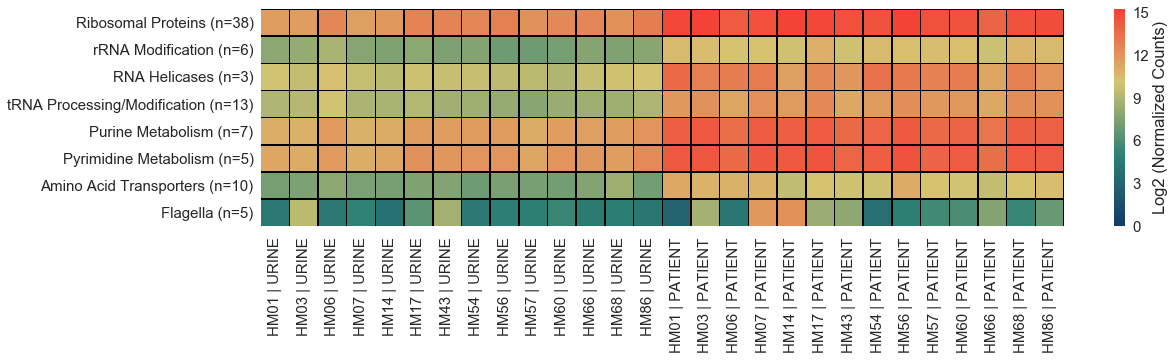

In [13]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(18,4))
sns.heatmap(np.log2(up_summary_no_LFC+1), cmap=my_cmap, linewidths=0.5, linecolor='black',
            vmin=0, cbar_kws={'label': 'Log2 (Normalized Counts)'})
ax = fig.gca()
#fn = os.path.join(results_dir, "Figure_4a.png")
#fig.savefig(fn, dpi=500, bbox_inches="tight")

In [14]:
# DOWN
arginine = get_subset_genes(de_edited, "Arginine", col_return, "Pathways")
val = get_subset_genes(de_edited, "Valine", col_return, "Pathways")
maltose = get_subset_genes(de_edited, "maltose", col_return)
cys = get_subset_genes(de_edited, "Cysteine", col_return, "Pathways" )
glycine = get_subset_genes(de_edited, "Glycine", col_return, "Pathways" )
galactose = get_subset_genes(de_edited, "Galactose", col_return, "Pathways" )
starch =  get_subset_genes(de_edited, "Starch", col_return, "Pathways" )

In [15]:
carb_transport_genes = get_go(go_analysis, ['GO:0034219'])
carb_transport = get_subset_genes(de_edited, carb_transport_genes, col_return, "Name")
biofilm_genes = get_go(go_analysis, ['GO:0042710'])
biofilm = get_subset_genes(de_edited[de_edited.log2FoldChange<0], biofilm_genes, col_return, 'Name')
carb_transport_up = carb_transport[carb_transport.log2FoldChange > 0] # make a sepearte figure for this
carb_transport_down = carb_transport[carb_transport.log2FoldChange < 0]
biofilm

,log2FoldChange,Name,Function
Entry,,,
b0836,-4.792774,bssR,repressor of biofilm formation by indole trans...
b1037,-2.226212,csgG,curli production assembly/transport outer memb...
b1038,-3.280083,csgF,curli nucleation outer membrane protein
b1039,-3.502387,csgE,curlin secretion specificity factor
b1040,-3.978146,csgD,csgBAC operon transcriptional regulator
b1041,-2.450621,csgB,"curlin nucleator protein, minor subunit in cur..."
b1042,-3.164985,csgA,"curlin subunit, amyloid curli fibers, cryptic"
b1205,-3.672422,ychH,DUF2583 family putative inner membrane protein
b3049,-3.889036,glgS,motility and biofilm regulator


In [16]:
down_subsets = {"Arginine Metabolism":arginine,
               "Val/Leu/Ileu Metabolism":val,
               "Cys/Met Metabolism": cys,
               "Gly/Ser/Thr Metabolism": glycine,
               "Maltose Metabolism": maltose,
               "Galactose Metabolism": galactose,
               "Starch/Sucrose Metabolism": starch,
                "Sugar Transporters":carb_transport_down,
               "Biofilm/Curli": biofilm,}

In [17]:
cnts_down = pd.concat(down_subsets.values(), axis=0, keys=down_subsets.keys(), names = ["Function", "Entry"],sort=False)
cnts_down = cnts_down.join(cnts, how='inner')
cnts_down.head()
down_summary = cnts_down.groupby(level=(0), sort=False).agg(['mean'])
down_summary_no_LFC = down_summary.iloc[:, 1:]
down_summary_no_LFC.columns = down_summary_no_LFC.columns.droplevel(level=1)
labels = []
sizes = cnts_down.groupby(level=0, sort=False).size()
for i,size in enumerate(sizes):
    labels.append("{} (n={})".format(sizes.index[i], size))
labels
down_summary_no_LFC.index = labels
down_summary_no_LFC

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Arginine Metabolism (n=10),4200.011906,3610.325569,4656.082387,1898.016133,5833.910586,3476.019080,3093.941386,6488.556284,5948.901204,2530.295692,...,993.436266,673.065612,687.022241,349.522215,401.809715,291.023287,341.279580,443.230955,471.748126,857.125964
Val/Leu/Ileu Metabolism (n=15),1329.343109,4246.974547,5306.946959,3992.126219,987.619890,14644.095311,1855.583241,2054.275157,11662.931415,1315.773465,...,233.843585,352.926013,510.206150,270.870899,281.015607,221.050475,152.388597,386.406474,218.625912,442.903735
Cys/Met Metabolism (n=8),8609.991309,10385.611690,16605.010303,5528.068682,22737.075653,35242.201788,28647.029016,26208.866650,33523.535724,41633.705758,...,1914.881847,981.661302,1848.524428,835.155881,615.374744,518.832499,534.246071,926.949354,885.367743,1184.388759
Gly/Ser/Thr Metabolism (n=8),4318.015800,4642.332871,4666.721501,3618.912475,5631.830345,7124.514266,5650.236769,6712.369086,6507.435624,6509.362436,...,1227.185976,617.963836,986.312988,822.370633,669.331188,486.032744,463.810644,628.620826,643.445627,1027.683052
Maltose Metabolism (n=5),5324.173739,796.825820,3621.996581,473.107327,3696.273385,158.762940,899.004882,5103.691789,1726.921931,1876.972395,...,14.222121,38.107770,518.381482,29.861636,50.399538,98.598053,82.927748,221.615478,36.960323,46.724472
Galactose Metabolism (n=21),3539.606926,2537.701996,2052.653216,1673.821783,2415.196874,1844.684573,953.508612,2480.936157,2217.019986,1303.301802,...,76.575493,147.624694,218.258019,171.141770,147.788120,138.203877,120.999584,182.650119,98.240859,156.599322
Starch/Sucrose Metabolism (n=8),1428.711565,1453.410554,1278.396291,1622.865034,1364.820286,1644.987797,1422.012581,1433.443943,1736.810648,2077.076477,...,175.576307,122.305343,418.168257,163.122123,192.238669,178.907758,151.502617,351.601479,120.121051,223.728515
Sugar Transporters (n=16),4734.733480,2619.020886,2719.784373,2759.787146,3928.416721,1096.916697,919.145967,4050.790056,1658.219442,2324.702847,...,177.116450,146.122699,499.717198,121.533330,170.949989,226.616494,214.628708,351.601479,159.601396,244.393881
Biofilm/Curli (n=10),1457.243937,702.843893,503.644984,842.025752,871.359867,294.819426,733.814139,583.951259,683.033785,447.851992,...,15.911878,20.083825,140.975433,13.284901,27.249511,27.830096,24.453054,51.142033,35.616311,239.239508


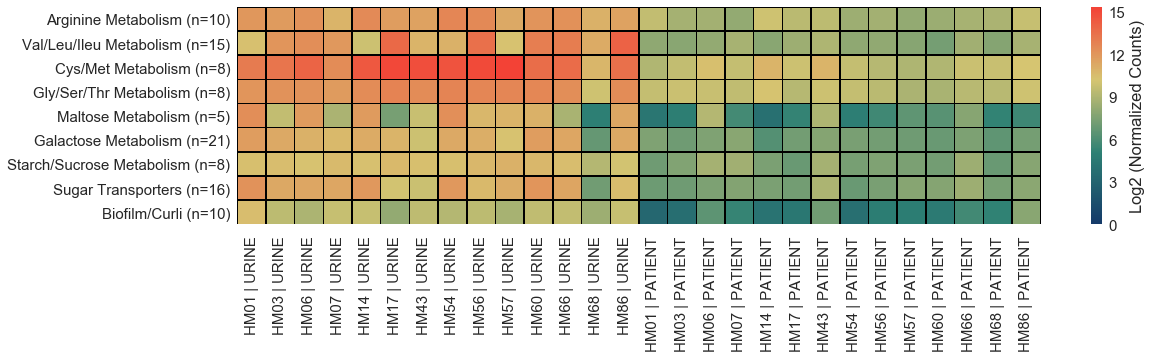

In [18]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(18,4))
sns.heatmap(np.log2(down_summary_no_LFC+1), cmap=my_cmap, linewidths=0.5, linecolor='black',
            vmin=0, cbar_kws={'label': 'Log2 (Normalized Counts)'})
ax = fig.gca()
#fn = os.path.join(results_dir, "Figure_4b.png")
#fig.savefig(fn, dpi=500, bbox_inches="tight")

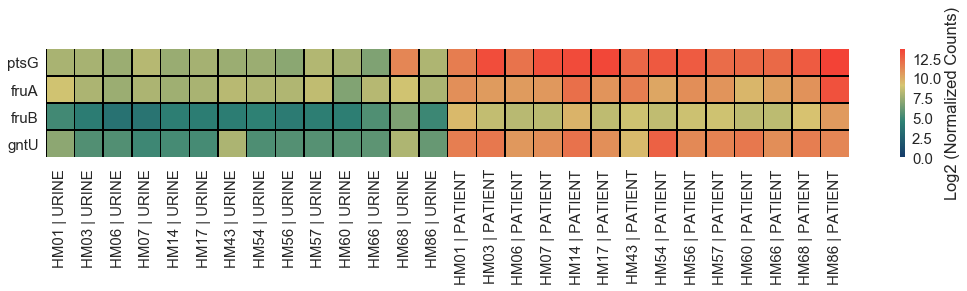

In [168]:
carbs_up = carb_transport_up.join(cnts, how="inner")
carbs_up_summary = carbs_up.groupby("Entry", sort=False).agg('mean').iloc[:,1:]
carbs_up_summary
labels = [carbs_up.loc[i]["Name"] for i in carbs_up.index]
carbs_up_summary.index = labels
fig = plt.figure(figsize=(18,2))
sns.heatmap(np.log2(carbs_up_summary+1), cmap=my_cmap, linewidths=0.5, linecolor='black',
            vmin=0, cbar_kws={'label': 'Log2 (Normalized Counts)'})

### Gene expression in B1 vs. B2 phylogroup 
#### Urine

In [23]:
de_urine = pd.read_csv(pg_urine_file, index_col=0)
de_urine = keggAPI.add_gene_info_to_file(pg_urine_file)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Name,Function,Pathways
Entry,,,,,,,,,
b3946,1068.094820,3.990681,0.415087,9.614076,6.973234e-22,1.838842e-18,fsaB,fructose-6-phosphate aldolase 2,
b2162,1464.953845,3.775959,0.653968,5.773922,7.744730e-09,6.588017e-07,rihB,ribonucleoside hydrolase 2,"eco00230 Purine metabolism, eco00240 Pyrimid..."
b1172,416.473668,3.363319,1.084547,3.101128,1.927848e-03,1.904020e-02,ymgG,UPF0757 family protein,
b4484,716.751011,3.050375,1.093455,2.789667,5.276220e-03,3.791115e-02,cpxP,inhibitor of the cpx response; periplasmic ada...,
b4106,7.515016,2.947846,0.928452,3.175011,1.498308e-03,1.606113e-02,phnC,phosphonate ABC transporter ATPase,eco02010 ABC transporters


In [45]:

de_urine = de_urine[["log2FoldChange", "padj", "Name", "Function", "Pathways"]].sort_index()
de_urine = de_urine.join(cnts[[c for c in cnts.columns if "UR" in c]], how='inner')
de_urine_for_hm = de_urine.iloc[:, 5:]

<Figure size 648x576 with 0 Axes>

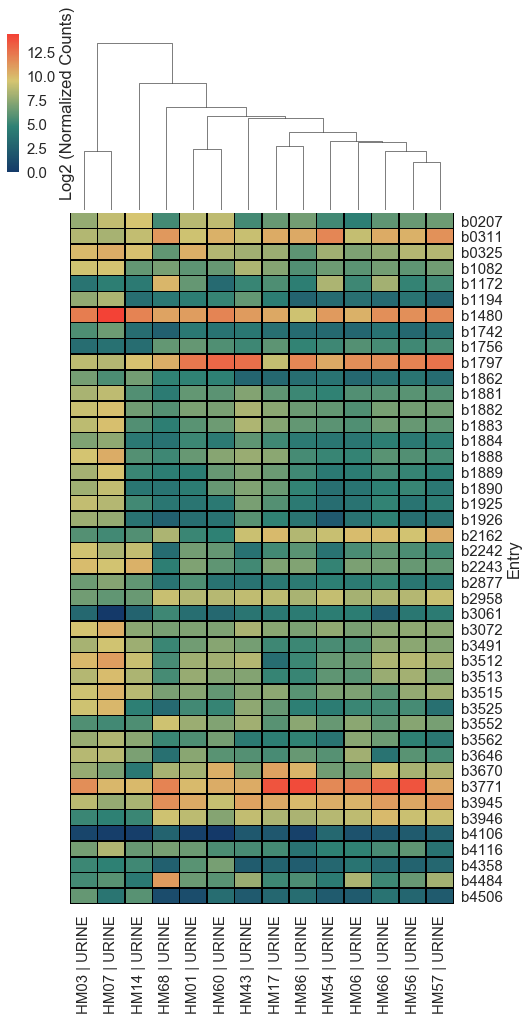

In [47]:
fig = plt.figure(figsize=(9,8))
sns.clustermap(np.log2(de_urine_for_hm+1), cmap=my_cmap, linewidths=0.5, linecolor='black', figsize=(8,16),
            row_cluster=False,vmin=0, cbar_kws={'label': 'Log2 (Normalized Counts)'})

In [18]:
#### Patients

,log2FoldChange,padj,Name,Function,Pathways
Entry,,,,,
b0061,-3.294363,5.492928e-08,araD,L-ribulose-5-phosphate 4-epimerase,eco00040 Pentose and glucuronate interconvers...
b0062,-3.201546,1.661233e-07,araA,L-arabinose isomerase,eco00040 Pentose and glucuronate interconvers...
b0063,-3.021728,2.918840e-05,araB,L-ribulokinase,eco00040 Pentose and glucuronate interconvers...
b0071,-5.486186,2.008811e-31,leuD,3-isopropylmalate dehydratase small subunit,"eco00290 Valine, leucine and isoleucine biosy..."
b0072,-5.078802,1.297481e-27,leuC,3-isopropylmalate dehydratase large subunit,"eco00290 Valine, leucine and isoleucine biosy..."


In [24]:
de_up.to_excel(os.path.join(results_dir, "UP_CHANGES_IN_GENE_EXPRESSION_IN_PATIENTS.xlsx"))
de_down.to_excel(os.path.join(results_dir, "DOWN_CHANGES_IN_GENE_EXPRESSION_IN_PATIENTS.xlsx"))

ModuleNotFoundError: No module named 'openpyxl'

In [2]:
# ...
gene_info_file = os.path.join(results_folder, "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/2018-05-24_all_gene_names_info.tab")
gene_info = pd.read_csv(gene_info_file, sep="\t", header=None, index_col=0,
                        names=["","gene_name", "function", "pathway"])
fx = gene_info.function
fx = fx.str.replace("\(RefSeq\)", "")
gene_info.function = fx
gene_info
df_all = de_all_genes[["baseMean", "log2FoldChange","padj"]]
df_all = df_all.merge(gene_info, how="left", left_index=True, right_index=True).sort_index()
df_all.head()

,baseMean,log2FoldChange,padj,gene_name,function,pathway
b0002,2524.965484,-0.055712,0.894307,thrA,Bifunctional aspartokinase/homoserine dehydro...,"eco00260 Glycine, serine and threonine metabo..."
b0003,1336.270850,-0.382777,0.487691,thrB,homoserine kinase,"eco00260 Glycine, serine and threonine metabo..."
b0004,1067.553271,-0.364933,0.456064,thrC,L-threonine synthase,"eco00260 Glycine, serine and threonine metabo..."
b0006,2319.560051,0.937212,0.020111,yaaA,"peroxide resistance protein, lowers intracell...",NaN
b0007,237.375000,-1.394198,0.000006,yaaJ,putative transporter,NaN


In [3]:
# ... 
gene_info_file = os.path.join(results_folder, "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/2018-05-24_up_gene_names_info.tab.txt")
gene_info = pd.read_csv(gene_info_file, sep="\t", header=None, index_col=0,
                        names=["gene_name", "function", "pathway"])
fx = gene_info.function
fx = fx.str.replace("\(RefSeq\)", "")
gene_info.function = fx
gene_info
df_up = de_up[["baseMean", "log2FoldChange","padj"]]
df_up = df_up.merge(gene_info, how="left", left_index=True, right_index=True).sort_index()
df_up.head()

#df_up.to_excel(os.path.join(results_folder, "UP_CHANGES_IN_GENE_EXPRESSION_IN_PATIENTS.xlsx"))

,baseMean,log2FoldChange,padj,gene_name,function,pathway
b0010,1172.258784,2.908446,2.750000e-06,satP,succinate-acetate transporter,NaN
b0013,65.848454,2.501710,3.835130e-04,yaaI,UPF0412 family protein,NaN
b0023,11151.703810,2.403709,1.260000e-17,rpsT,30S ribosomal subunit protein S20,eco03010 Ribosome
b0048,1274.772119,2.397252,2.500000e-52,folA,dihydrofolate reductase,"eco00670 One carbon pool by folate, eco00790 ..."
b0058,527.258884,2.085799,2.760000e-09,rluA,"dual specificity 23S rRNA pseudouridine(746),...",NaN


In [4]:
# ... 
gene_info_file = os.path.join(results_folder, "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/2018-05-24_down_gene_names_info.tab")
gene_info = pd.read_csv(gene_info_file, sep="\t", header=None, index_col=0,
                        names=["","gene_name", "function", "pathway"])

fx = gene_info.function
fx = fx.str.replace("\(RefSeq\)", "")
gene_info.function = fx
gene_info
df_down = de_down[["baseMean", "log2FoldChange","padj"]]
df_down = df_down.merge(gene_info, how="left", left_index=True, right_index=True).sort_index()
df_down.head()
#df_down.to_excel(os.path.join(results_folder, "DOWN_CHANGES_IN_GENE_EXPRESSION_IN_PATIENTS.xlsx"))

,baseMean,log2FoldChange,padj,gene_name,function,pathway
b0061,122.611605,-3.181688,2.290000e-05,araD,L-ribulose-5-phosphate 4-epimerase,eco00040 Pentose and glucuronate interconvers...
b0062,356.064598,-3.642759,1.230000e-09,araA,L-arabinose isomerase,eco00040 Pentose and glucuronate interconvers...
b0063,293.901383,-3.802945,3.480000e-07,araB,L-ribulokinase,eco00040 Pentose and glucuronate interconvers...
b0071,5679.636684,-4.546992,1.570000e-08,leuD,3-isopropylmalate dehydratase small subunit,"eco00290 Valine, leucine and isoleucine biosy..."
b0072,13398.715840,-4.372419,3.300000e-08,leuC,3-isopropylmalate dehydratase large subunit,"eco00290 Valine, leucine and isoleucine biosy..."


In [5]:
def get_subset_genes(df, key, col_return,column_name="Function"):
    keep = []
    for i, x in zip(df.index, df[column_name]):
        if not type(x) == str:
            continue
        if key in x:
            keep.append(i)
    return df.loc[keep][col_return]

In [14]:
down_data = find_subset_means(down_subsets, df, )
down_data.head()

,HM01 | URINE,HM03 | URINE,HM06 | URINE,HM07 | URINE,HM14 | URINE,HM17 | URINE,HM43 | URINE,HM54 | URINE,HM56 | URINE,HM57 | URINE,...,HM14 | PATIENT,HM17 | PATIENT,HM43 | PATIENT,HM54 | PATIENT,HM56 | PATIENT,HM57 | PATIENT,HM60 | PATIENT,HM66 | PATIENT,HM68 | PATIENT,HM86 | PATIENT
Arginine Metabolism (n=9),4065.878321,3724.800930,4890.792230,1949.636333,6206.768160,3470.706276,3096.547075,6896.670845,6282.175410,2523.747981,...,1061.427231,692.912960,618.668722,343.981238,399.703841,275.505928,364.657547,420.691033,462.637091,846.827856
Val/Leu/Ileu Metabolism (n=12),1315.228160,5054.292258,6360.968832,4727.997453,985.312496,17860.895242,2085.863152,1904.151119,14232.024084,1337.595053,...,219.571209,348.595100,498.178219,277.364235,308.321425,213.891184,140.755437,364.598895,234.679105,439.903666
Cys/Met Metabolism (n=8),8614.074061,10360.169656,16597.555401,5507.771703,22730.194888,35171.455030,28714.576304,26203.046278,33507.396036,41538.171197,...,1916.594158,978.418764,1848.729314,834.294784,615.587470,516.903694,537.186891,915.002997,885.507555,1184.388759
Gly/Ser/Thr Metabolism (n=8),4320.063351,4630.960369,4664.626353,3605.625196,5630.126023,7110.212201,5663.559552,6710.878426,6504.302662,6494.425762,...,1228.283341,615.922632,986.422308,821.522719,669.562566,484.225875,466.363744,620.519274,643.547237,1027.683052
Maltose Metabolism (n=5),5326.698398,794.873805,3620.370467,471.370256,3695.154807,158.444232,901.124660,5102.558379,1726.090516,1872.665410,...,14.234838,37.981896,518.438938,29.830846,50.416961,98.231507,83.384234,218.759337,36.966160,46.724472


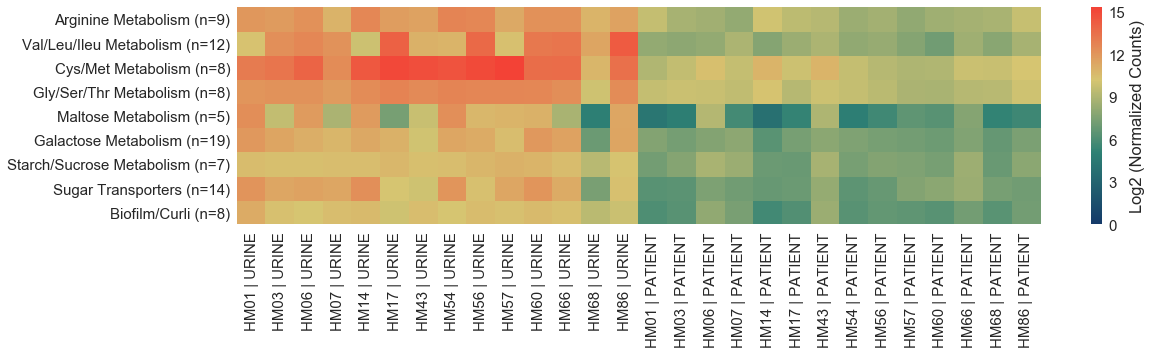

In [16]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(18,4))
sns.heatmap(np.log2(down_data+1), cmap=my_cmap, vmin=0, cbar_kws={'label': 'Log2 (Normalized Counts)'})
ax = fig.gca()
#fn = os.path.join(figures_folder, today+"_figure_4b_v1.png")
#fig.savefig(fn, dpi=500, bbox_inches="tight")

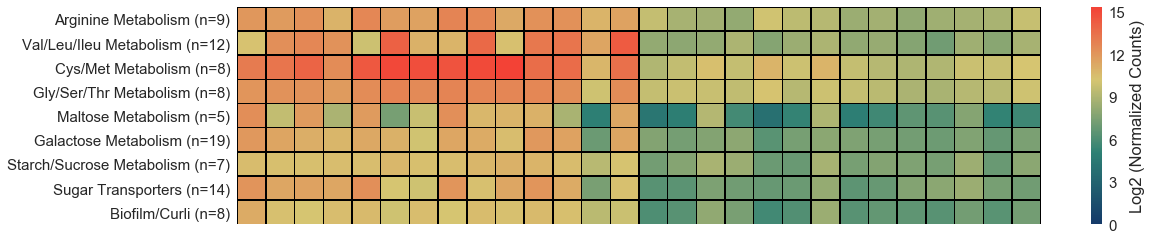

In [22]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(18,4))
sns.heatmap(np.log2(down_data+1), cmap=my_cmap, vmin=0, linecolor="black", linewidths=0.5,
            cbar_kws={'label': 'Log2 (Normalized Counts)'});
ax = fig.gca()
ax.set_xticklabels("")
fn = os.path.join(figures_folder, today+"_figure_4b_v2.png")
fig.savefig(fn, dpi=500, bbox_inches="tight")

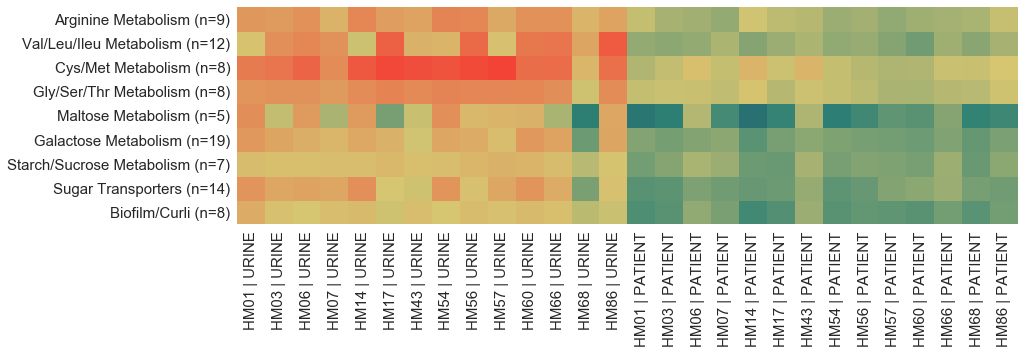

In [259]:
sns.set_context("notebook", font_scale=1.5)
fig = plt.figure(figsize=(14,4))
sns.heatmap(np.log2(down_data+1), cmap=my_cmap, vmin=0, cbar=False)
#fn = os.path.join(figures_folder, today+"_figure_4b_v1.png")
#fig.savefig(fn, dpi=500, bbox_inches="tight")

In [2]:
file = "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/pg_contr_de_genes_DSeq2_norm_counts.csv"

In [3]:
cnts = pd.read_csv(file, index_col=0)

In [4]:
cnts.head()

,HM03_UR,HM03_UTI,HM06_UR,HM06_UTI,HM07_UR,HM07_UTI,HM14_UR,HM14_UTI,HM17_UR,HM17_UTI,...,HM57_UR,HM57_UTI,HM60_UR,HM60_UTI,HM66_UR,HM66_UTI,HM68_UR,HM68_UTI,HM86_UR,HM86_UTI
b4182,48.275274,15.213524,67.848666,37.531993,63.660071,36.698818,11.425505,2.815322,171.056518,117.599293,...,63.197293,167.077908,28.583398,31.720616,62.494339,170.304804,25.117646,16.648910,36.393858,24.257380
b1960,84.417191,120.621512,75.879732,82.883152,108.674932,69.319989,93.256828,118.947351,94.911106,158.503395,...,48.851895,182.990090,58.881800,84.588310,45.366261,170.304804,96.736880,166.489103,60.324065,100.859632
b2866,236.213241,18.473565,593.191193,143.872641,314.571312,81.552929,234.686056,13.372779,631.537778,46.017115,...,586.222740,206.858363,336.712427,52.867694,823.073594,340.609607,93.342603,26.638256,576.817717,25.534084
b0328,215.560717,22.820286,58.155999,82.883152,279.678135,16.310586,221.407766,22.522575,189.100455,5.113013,...,159.737942,95.473090,621.974737,222.044314,471.253610,340.609607,24.438791,16.648910,136.103057,7.660225
b1660,760.787344,2003.838450,826.092124,1566.960718,773.509813,1162.129233,768.905631,774.917359,473.112016,255.650638,...,193.856726,835.389541,384.732535,1332.265884,325.433485,340.609607,613.685189,1008.923964,317.075253,439.186245


In [5]:
fl = ["b1071",
     "b1072",
     "b1073",
     "b1074",
     "b1075",
     "b1076",
     "b1077",
     "b1078",
     "b1079",
     "b1080",
     "b1081"]
     

In [6]:
fl_df = cnts.loc[fl]
uti_cols = [c for c in fl_df.columns if "UTI" in c]

In [7]:
fl_df

,HM03_UR,HM03_UTI,HM06_UR,HM06_UTI,HM07_UR,HM07_UTI,HM14_UR,HM14_UTI,HM17_UR,HM17_UTI,...,HM57_UR,HM57_UTI,HM60_UR,HM60_UTI,HM66_UR,HM66_UTI,HM68_UR,HM68_UTI,HM86_UR,HM86_UTI
b1071,193.359254,40.207171,52.617333,21.893663,355.324411,754.364590,40.761262,325.873512,84.445623,97.147242,...,71.339275,7.956091,52.021784,10.573539,84.714549,255.457205,46.841016,26.638256,90.236825,58.728393
b1072,163.413094,85.847743,35.447466,23.457496,30.631415,1329.312737,28.100567,1091.641075,20.930966,97.147242,...,18.610246,39.780454,29.726734,31.720616,38.422446,85.152402,19.686804,26.638256,17.449110,58.728393
b1073,273.387783,130.401635,1.938533,10.946831,5.327203,1655.524451,1.235190,1534.350448,35.005237,189.181472,...,3.489421,15.912182,20.008378,31.720616,10.647184,85.152402,3.054849,26.638256,1.994184,81.709069
b1074,415.890197,198.862493,4.430933,4.691499,6.925363,1639.213865,5.558354,2920.896494,25.261511,158.503395,...,6.203415,23.868273,17.721707,42.294155,4.629210,85.152402,5.091415,26.638256,8.973828,44.684647
b1075,603.570007,294.490358,14.123600,10.946831,30.897775,3368.135952,11.425505,3706.371311,80.115078,352.797880,...,13.569971,23.868273,33.728409,21.147078,19.905604,170.304804,10.522257,46.616949,17.449110,154.481208
b1076,1600.570592,1193.174956,63.140799,51.606491,102.282289,10344.988996,42.922844,13003.268128,236.375569,797.629990,...,108.559767,135.253545,110.903584,190.323698,40.274130,510.914411,70.261523,83.244552,52.845876,242.573798
b1077,236.471397,159.742002,15.508266,17.202164,17.047048,1704.456208,5.249557,658.081499,57.740597,148.277370,...,19.385673,31.824363,21.723382,10.573539,11.110105,0.000000,14.595389,23.308474,17.449110,80.432365
b1078,336.119824,202.122534,20.493066,15.638331,28.766894,2002.124398,12.660695,1806.029013,52.327416,153.390383,...,5.815702,55.692636,25.153390,10.573539,44.440419,170.304804,46.501588,26.638256,18.446202,61.281802
b1079,150.505267,108.668029,12.738933,14.074497,9.056244,660.578722,12.351898,874.861287,36.448752,61.356153,...,9.305123,55.692636,15.435035,10.573539,16.665157,0.000000,26.814784,19.978692,16.950564,21.703971
b1080,324.760936,233.636262,36.832133,43.787325,35.958617,1696.300915,25.630188,1800.398369,76.867170,173.842434,...,37.995918,39.780454,38.873421,84.588310,46.755024,85.152402,72.976944,49.946731,28.915668,52.344872


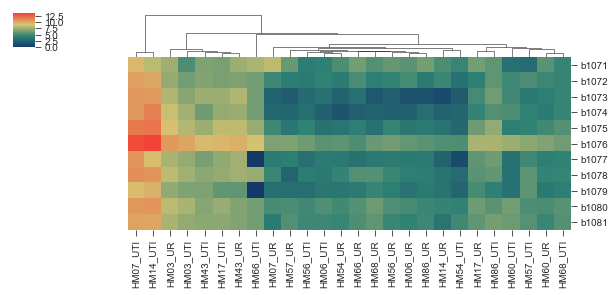

In [59]:
sns.clustermap(np.log2(fl_df+1), cmap=my_cmap, figsize=(10,4), row_cluster=False)

In [8]:
uti = fl_df[uti_cols]

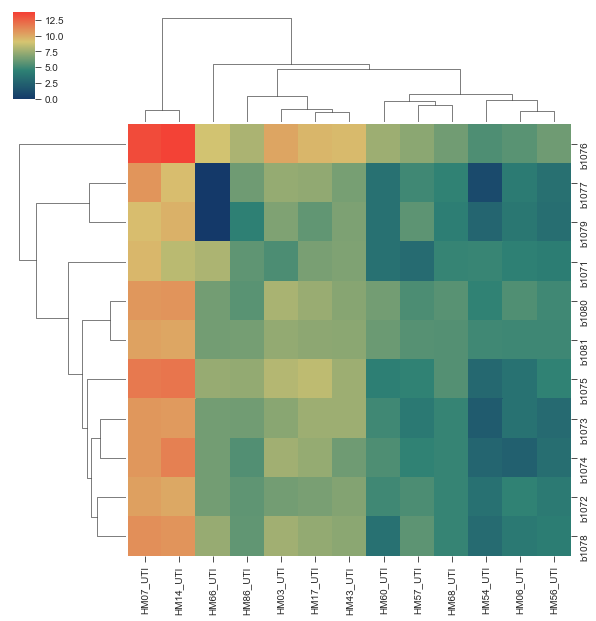

In [9]:
sns.clustermap(np.log2(uti+1), cmap=my_cmap)

In [10]:
mot = ["b1880",
     "b1882",
     "b1888",
     "b1889",
     "b1890"]

In [60]:
flhdc = ["b1891", "b1892"]

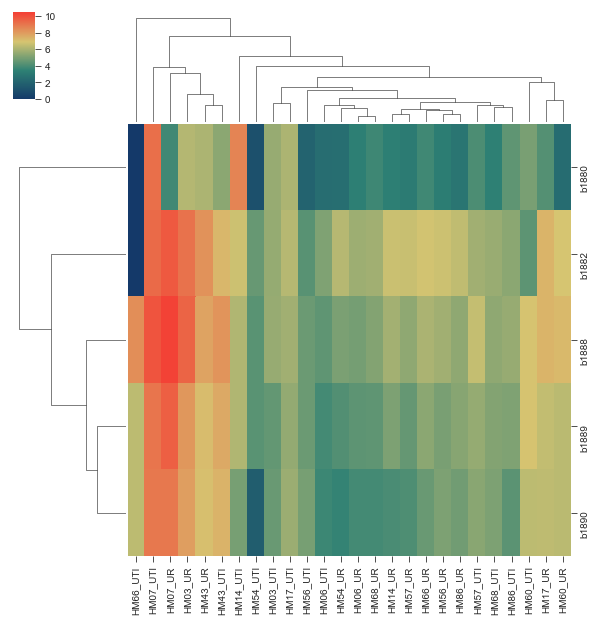

In [12]:
mot_df = cnts.loc[mot]
sns.clustermap(np.log2(mot_df+1), cmap=my_cmap)

In [65]:
flhdc_df

,HM03_UR,HM03_UTI,HM06_UR,HM06_UTI,HM07_UR,HM07_UTI,HM14_UR,HM14_UTI,HM17_UR,HM17_UTI,...,HM57_UR,HM57_UTI,HM60_UR,HM60_UTI,HM66_UR,HM66_UTI,HM68_UR,HM68_UTI,HM86_UR,HM86_UTI
b1891,1277.616751,163.002043,145.666932,34.404327,1547.818706,566.792854,298.915924,295.608802,503.064950,168.729421,...,78.318117,47.736545,726.589973,243.191392,387.464903,85.152402,15.613672,126.531718,227.336974,174.908475
b1892,1962.506070,239.069663,321.796530,82.883152,2321.594878,701.355186,413.479775,560.249063,893.896616,383.475956,...,165.553644,87.517000,931.247102,444.088628,571.244553,170.304804,29.530205,239.744308,402.825164,337.049909


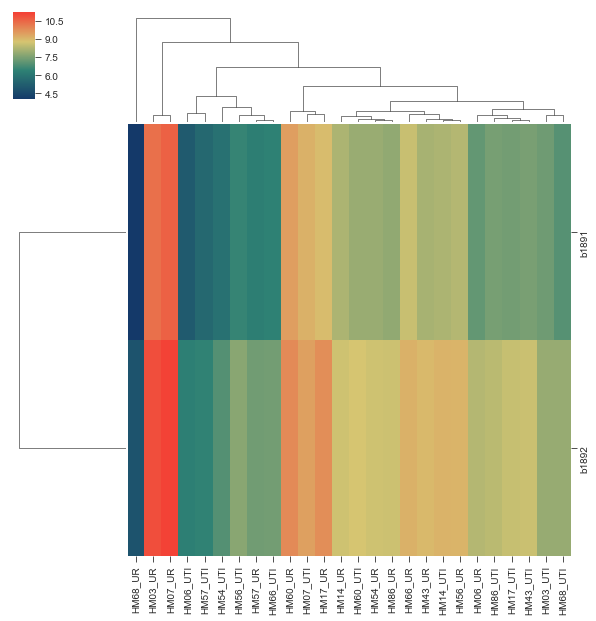

In [67]:
sns.clustermap(np.log2(flhdc_df+1), cmap=my_cmap)

In [27]:
file = "/Users/annasintsova/git_repos/HUTI-RNAseq/results/differential_expression_analysis/pg_uti_de_genes_significant.csv"

In [28]:
pg_de = pd.read_csv(file, index_col=0)

In [29]:
pg_de

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
b3946,61.142421,4.870742,0.624181,7.803411,6.025596e-15,7.646482e-12
b3078,23.030877,4.419339,0.995705,4.438401,9.062982e-06,7.419951e-04
b4671,15.116153,4.234413,1.368644,3.093875,1.975610e-03,4.097683e-02
b2162,7.780051,4.001266,1.053290,3.798828,1.453821e-04,5.765309e-03
b2870,18.966370,3.875912,1.097708,3.530913,4.141275e-04,1.330450e-02
b4322,595.160257,3.849033,0.498536,7.720667,1.157222e-14,9.790096e-12
b0063,37.951856,3.609119,1.082920,3.332765,8.598763e-04,2.269254e-02
b0698,20.301469,3.557913,0.905191,3.930566,8.474624e-05,3.773438e-03
b3077,13.710397,3.542052,0.882231,4.014882,5.947563e-05,2.884674e-03
b0294,75.149929,3.464250,0.911714,3.799713,1.448640e-04,5.765309e-03


In [36]:
df = cnts.loc[pg_de.index].sort_index()

In [31]:
len(pg_de.index)

61

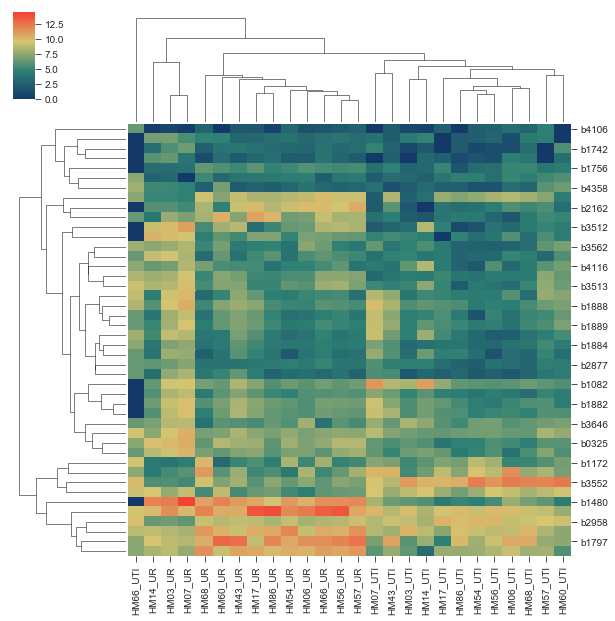

In [26]:
sns.clustermap(np.log2(df+1), cmap=my_cmap)

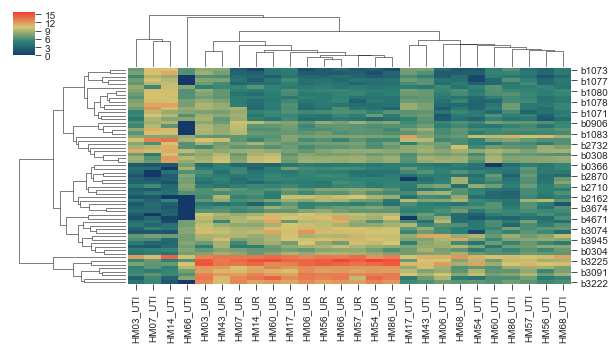

In [39]:
sns.clustermap(np.log2(df+1), cmap=my_cmap, figsize = (10, 5), )